In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.lightgbm
from sklearn.metrics import roc_auc_score, roc_curve
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [42]:
booster = mlflow.lightgbm.load_model('runs:/78d83764c6e2495da05ad665e570c2e9/model')
pyfunc_model = mlflow.pyfunc.load_model(tlogged_model)

In [43]:
df = pd.read_csv("base_modelo.csv")

df["safra"] = df["safra"].astype(str)
df["period_label"] = np.where(
    df["safra"].between("201402","201409"), "DEV",
    np.where(df["safra"].between("2014010","201412"), "OOT", np.nan)
)
dev = df[df["period_label"]=="DEV"].copy()
oot = df[df["period_label"]=="OOT"].copy()

In [44]:
feature_list = ['VAR_6',  'VAR_9',  'VAR_10',  'VAR_12',  'VAR_14',  'VAR_16',  'VAR_17',  'VAR_18',  'VAR_19',  'VAR_20',  'VAR_25',
 'VAR_27',  'VAR_29',  'VAR_31',  'VAR_32',  'VAR_33',  'VAR_34',  'VAR_37',  'VAR_38',  'VAR_40',  'VAR_41',  'VAR_42',  'VAR_43',
 'VAR_46',  'VAR_47',  'VAR_48',  'VAR_49',  'VAR_51',  'VAR_53',  'VAR_57',  'VAR_59',  'VAR_62',  'VAR_64',  'VAR_65',  'VAR_66',
 'VAR_67',  'VAR_70',  'VAR_71',  'VAR_72',  'VAR_76',  'VAR_77']

In [45]:
scaler = StandardScaler()
scaler.fit(dev[feature_list])

StandardScaler()

In [46]:
def ks_score(y, p):
    fpr, tpr, _ = roc_curve(y, p)
    return np.max(np.abs(tpr - fpr)) * 100

In [50]:
results = []
for safra, grp in df.groupby('safra'):
    X_raw    = grp[feature_list]
    X_scaled = scaler.transform(X_raw)
    probs = booster.predict(X_scaled, raw_score=True)      
    y_true   = grp['y'].values

    auc  = roc_auc_score(y_true, probs)
    gini = (2*auc - 1) * 100    # agora Gini em %
    ks   = ks_score(y_true, probs)  # já está em %

    results.append({
        'safra': safra,
        'auc':   auc,
        'gini':  gini,
        'ks':    ks
    })

metrics_df = pd.DataFrame(results)
metrics_df

,safra,auc,gini,ks
0,201401,0.727720,45.543931,39.260632
1,201402,0.662077,32.415488,24.552853
2,201403,0.671092,34.218416,27.810704
3,201404,0.645057,29.011433,23.789375
4,201405,0.677500,35.500098,28.537742
5,201406,0.685678,37.135517,30.876025
6,201407,0.651087,30.217358,24.919295
7,201408,0.670859,34.171741,25.635786
8,201409,0.742151,48.430166,39.722074
9,201410,0.658684,31.736763,25.345786


   feature          gain  rel_gain_%
1    VAR_9  23005.390453   23.737471
6   VAR_17  19190.685122   19.801374
0    VAR_6  15056.182615   15.535303
9   VAR_20   8385.343025    8.652183
29  VAR_57   7783.548856    8.031238
11  VAR_27   4429.438515    4.570393
17  VAR_37   3911.064117    4.035523
33  VAR_65   3490.062504    3.601124
28  VAR_53   2520.302403    2.600504
12  VAR_29   1719.767607    1.774494
13  VAR_31   1394.020706    1.438381
5   VAR_16   1351.981094    1.395004
21  VAR_42   1135.255581    1.171382
38  VAR_72    959.065153    0.989585
18  VAR_38    923.063873    0.952438
14  VAR_32    466.470704    0.481315
23  VAR_46    361.288417    0.372785
10  VAR_25    356.136095    0.367469
35  VAR_67    284.028105    0.293066
16  VAR_34    192.832640    0.198969


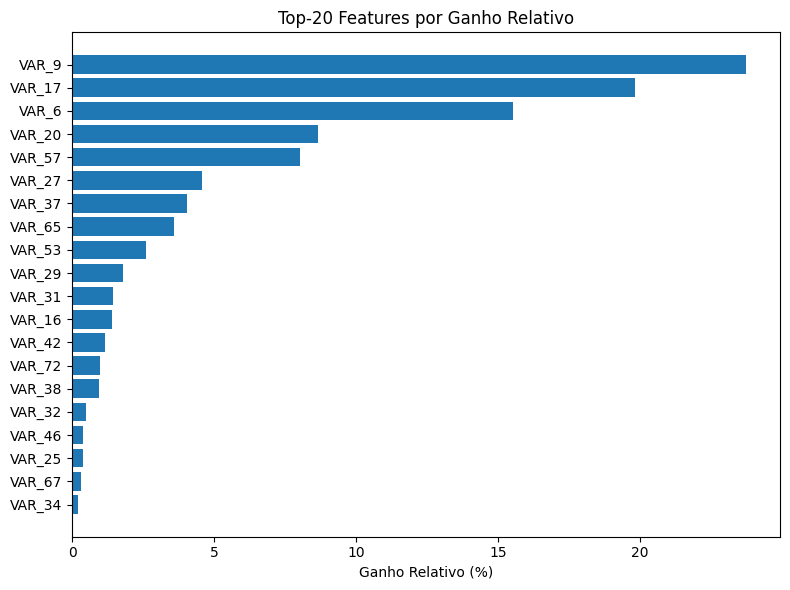

In [ ]:
model_uri = 'runs:/78d83764c6e2495da05ad665e570c2e9/model'
loaded = mlflow.lightgbm.load_model(model_uri)

if isinstance(loaded, LGBMClassifier):
    booster = loaded.booster_
else:
    booster = loaded  # já é lgb.Booster

gain = booster.feature_importance(importance_type='gain')
names = feature_list

fi = pd.DataFrame({'feature': names, 'gain': gain})
fi = fi.sort_values('gain', ascending=False).head(20)

# 4) Calcula ganho relativo (%) e exibe
fi['rel_gain_%'] = fi['gain'] / fi['gain'].sum() * 100
print(fi[['feature','gain','rel_gain_%']])

plt.figure(figsize=(8,6))
plt.barh(fi['feature'][::-1], fi['rel_gain_%'][::-1])
plt.xlabel('Ganho Relativo (%)')
plt.title('Top-20 Features por Ganho Relativo')
plt.tight_layout()
plt.show()

In [58]:
fi.to_excel("fi.xlsx")

c:\Users\vitor\OneDrive\Área de Trabalho\Vitor\Modelos\Teste_Picpay\venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


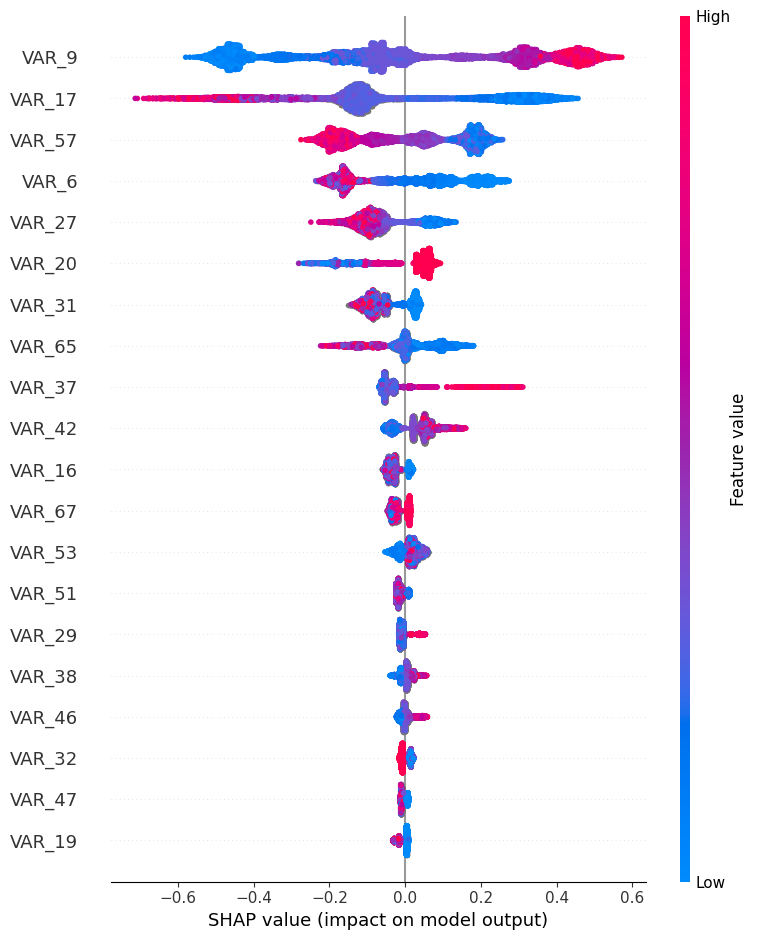

In [59]:
X_all_scaled = scaler.transform(df[feature_list])
explainer = shap.TreeExplainer(booster)
shap_vals = explainer.shap_values(X_all_scaled)

plt.figure()
shap.summary_plot(
    shap_vals,
    X_all_scaled,
    feature_names=feature_list,
    show=True
)

In [61]:
psi_df

,safra,feature,psi
0,201401,VAR_9,0.028513
1,201401,VAR_17,0.000000
2,201401,VAR_6,0.000000
3,201401,VAR_20,0.008142
4,201401,VAR_57,0.016880
...,...,...,...
115,201412,VAR_27,0.000000
116,201412,VAR_37,0.000000
117,201412,VAR_65,0.000000
118,201412,VAR_53,0.000000


In [64]:
# Diagnóstico de variabilidade por feat e safra
variabilidade = []
for feat in top_feats:
    n_base = baseline[feat].nunique()
    for safra, grp in df.groupby('safra'):
        n_grp = grp[feat].nunique()
        variabilidade.append({
            'feature': feat,
            'baseline_nunique': n_base,
            'safra': safra,
            'grp_nunique': n_grp
        })

variab_df = pd.DataFrame(variabilidade)
print(variab_df.pivot_table(
    index='feature', values=['baseline_nunique','grp_nunique'], 
    aggfunc='max'
))


         baseline_nunique  grp_nunique
feature                               
VAR_17               1284          355
VAR_20                 10           10
VAR_27                883          353
VAR_29                145           79
VAR_37                147           78
VAR_53               2523          443
VAR_57                 61           61
VAR_6                2961          805
VAR_65               5524          751
VAR_9                1480          281


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

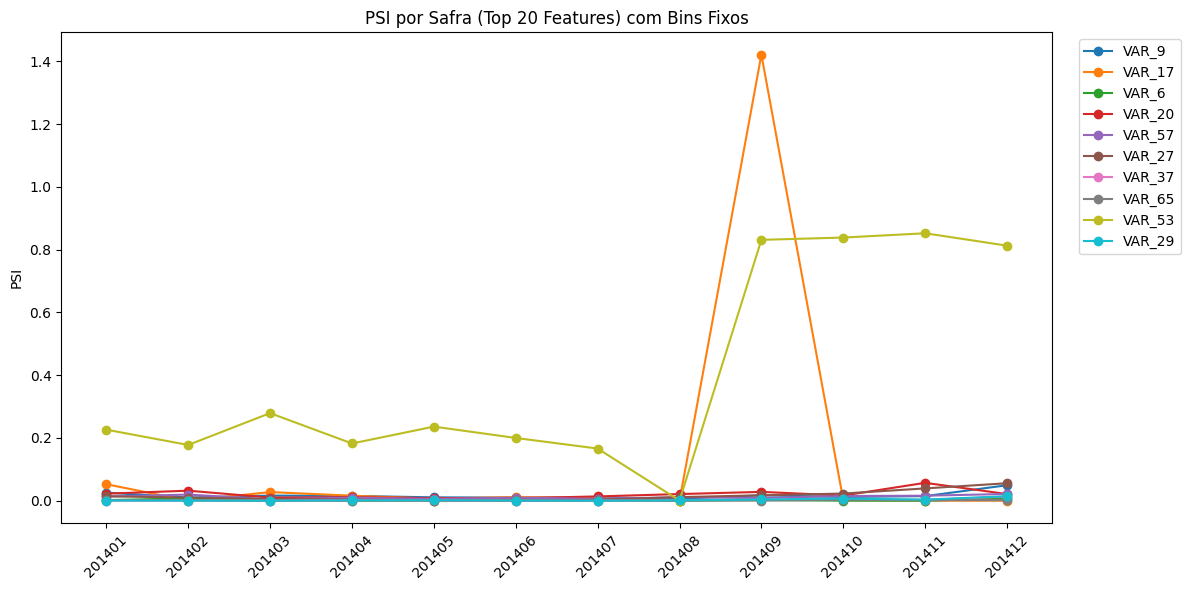

In [69]:
# top20 features por ganho já calculadas em fi
top_feats = fi['feature'].tolist()[:10]

def psi_fixed_bins(expected, actual, bins=10):
    if expected.min() == expected.max():
        return np.nan
    breaks = np.linspace(expected.min(), expected.max(), bins+1)
    exp_perc = np.histogram(expected, bins=breaks)[0] / len(expected)
    act_perc = np.histogram(actual,   bins=breaks)[0] / len(actual)
    exp_perc = np.where(exp_perc == 0, 1e-8, exp_perc)
    act_perc = np.where(act_perc == 0, 1e-8, act_perc)
    return np.sum((exp_perc - act_perc) * np.log(exp_perc / act_perc))

# recalcula o psi_df usando bins fixos
psi_records = []
for safra, grp in df.groupby('safra'):
    for feat in top_feats:
        psi_val = psi_fixed_bins(
            baseline[feat].values,
            grp[feat].values,
            bins=10
        )
        psi_records.append({
            'safra': safra,
            'feature': feat,
            'psi': psi_val
        })

psi_df = pd.DataFrame(psi_records)

# plota
plt.figure(figsize=(12,6))
for feat in top_feats:
    series = psi_df[psi_df['feature'] == feat].set_index('safra')['psi']
    plt.plot(series.index, series.values, marker='o', label=feat)

plt.xticks(rotation=45)
plt.ylabel('PSI')
plt.title('PSI por Safra (Top 20 Features) com Bins Fixos')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [71]:
psi_df.to_excel("pdi_df_valida.xlsx")